In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from unet import UNetModel

from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

## Load Data

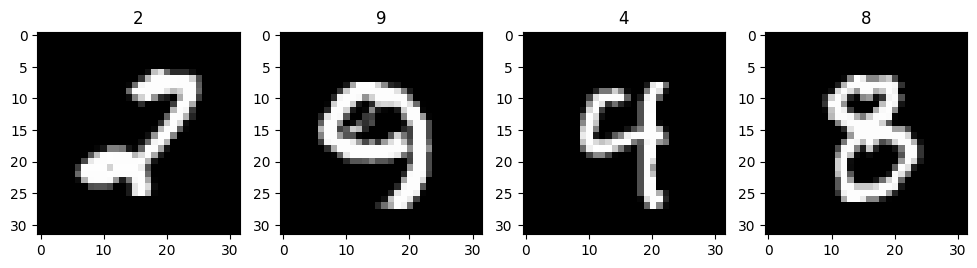

In [2]:
# Load MNIST dataset
device = torch.device('cuda:0')
batch_size = 128

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Pad(2), # Make MNIST images 32x32
    torchvision.transforms.Normalize(0.5, 0.5),
])
mnist_train = torchvision.datasets.MNIST(root='data/', train=True, transform=transforms, download=True)
data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)

for batch in data_loader:
    img, labels = batch
    break
    
fig, ax = plt.subplots(1, 4, figsize=(12,3))
for i in range(4):
    ax[i].imshow(img[i,0,:,:].numpy())
    ax[i].set_title(str(labels[i].item()))
plt.show()

## Diffusion schedule

In [3]:
class GaussianDiffusionSchedule():
    '''Gaussian Diffusion process with linear beta scheduling'''
    def __init__(self, T, schedule):
        # Diffusion steps
        self.T = T
    
        # Noise schedule
        if schedule == 'linear':
            b0=1e-4
            bT=2e-2
            self.beta = torch.linspace(b0, bT, T)
        elif schedule == 'cosine':
            self.alphabar = self.__cos_noise(torch.arange(0, T+1, 1)) / self.__cos_noise(0) # Generate an extra alpha for bT
            self.beta = torch.clip(1 - (self.alphabar[1:] / self.alphabar[:-1]), None, 0.999)
            
        self.betabar = torch.cumprod(self.beta, 0)
        self.alpha = 1 - self.beta
        self.alphabar = torch.cumprod(self.alpha, 0)

    def __cos_noise(self, t):
        offset = 0.008
        return torch.cos(torch.pi * 0.5 * (t/self.T + offset) / (1+offset)) ** 2

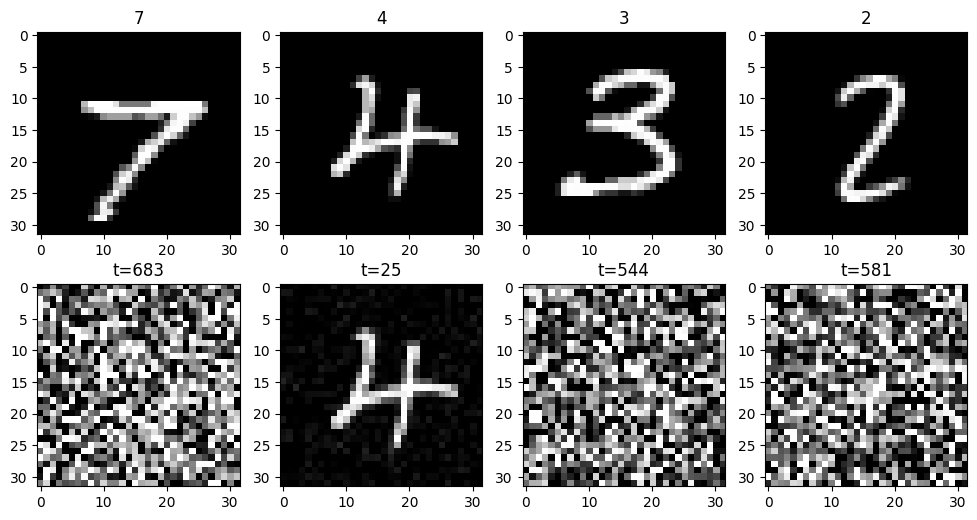

In [4]:
# Sample from diffusion process
schedule = GaussianDiffusionSchedule(T=1000, schedule='linear')

x0, y = next(iter(data_loader))
t = np.random.randint(1, schedule.T+1, batch_size).astype(int)
xt = schedule.alphabar[t].sqrt().view(-1,1,1,1)*x0 + (1-schedule.alphabar[t]).sqrt().view(-1,1,1,1)*torch.randn_like(x0)

fig, ax = plt.subplots(2, 4, figsize=(12,6))
for i in range(4):
    ax[0,i].imshow(x0[i,0,:,:].numpy(), vmin=-1, vmax=1)
    ax[0,i].set_title(str(y[i].item()))
    
    ax[1,i].imshow(xt[i,0,:,:].numpy(), vmin=-1, vmax=1)
    ax[1,i].set_title(f't={t[i]}')
plt.show()

## Train denoiser network

In [5]:
net = UNetModel(image_size=32, in_channels=1, out_channels=1, 
                model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[8,4], num_heads=4).to(device)
net.train()
print(f'# parameters: {sum([p.numel() for p in net.parameters()]):,d}')

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

schedule = GaussianDiffusionSchedule(T=1000, schedule='linear')

# parameters: 22,078,017


In [ ]:
# Train network
epochs = 50
update_every = 20
for e in range(epochs):
    print(f'Epoch [{e+1}/{epochs}]')
    
    losses = []
    batch_bar = tqdm(data_loader)
    for i, batch in enumerate(batch_bar):
        img, labels = batch
        
        # Sample from the diffusion process
        t = torch.randint(0, schedule.T, (img.shape[0],)).long()
        epsilon = torch.randn_like(img)
        at = schedule.alphabar[t].view(-1,1,1,1)
        xt = at.sqrt()*img + (1-at).sqrt()*epsilon
        
        # Pass through network
        out = net(xt.float().to(device), t.to(device))

        # Compute loss and backprop
        loss = F.mse_loss(out, epsilon.float().to(device))
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Loss tracking 
        losses.append(loss.item())
        if len(losses) > 100:
            losses = losses[-100:]
        if i % update_every == 0:
            batch_bar.set_postfix({'Loss': np.mean(losses)})
            losses = []
        

In [ ]:
# Save/Load model
torch.save(net.state_dict(), 'mnist_unet.pth')
print('Saved model')

## Sample from trained model

In [6]:
# Load model
net.load_state_dict(torch.load('mnist_unet.pth'))
net.to(device)
net.eval();
print('Loaded model')

Loaded model


0it [00:00, ?it/s]

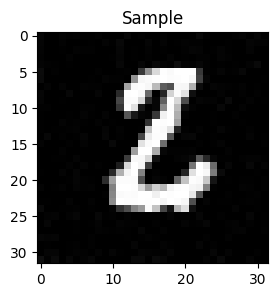

In [8]:
# Model forward pass
def model_pred(model, x, t):
    with torch.no_grad():
        t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)
        epsilon = model(x, t_cond)
    return epsilon

# Diffusion parameters
t = 1000
xt = torch.randn((1,1,32,32), device=device)
stride = 20
timesteps = range(t, 0, -stride)

# Run inference
for idx, t in tqdm(enumerate(timesteps)):
    atbar = torch.Tensor([schedule.alphabar[t-1]]).view(1,1,1,1).to(device)
    atbar_prev = torch.Tensor([schedule.alphabar[max(t-1-stride,1)]]).view(1,1,1,1).to(device)

    # Compute x_0(x_t, t)
    epsilon = model_pred(net, xt, t)
    x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

    # DDIM step
    xt = torch.sqrt(atbar_prev)*x0_pred + torch.sqrt(1-atbar_prev)*epsilon

plt.figure(figsize=(3,3))
plt.imshow(xt.cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
plt.title("Sample")
plt.show()

## Constrained sampling

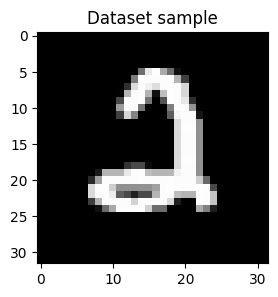

In [32]:
# Select an image to experiment with
for batch in data_loader:
    img, labels = batch
    img = img[[0],...]
    break

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(img.cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
ax.set_title("Dataset sample")
plt.show()

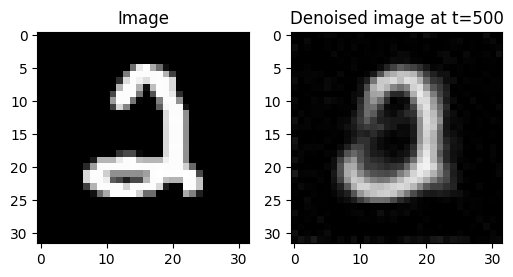

In [34]:
# Add noise to a specific timestep
t = 500

# Initialize latent
if t == 1000:
    xt = torch.randn((1,1,32,32), device=device)
else:
    atbar = torch.Tensor([schedule.alphabar[t]]).view(1,1,1,1).to(device)
    xt = atbar.sqrt()*img.to(device) + (1-atbar).sqrt()*torch.randn_like(img.to(device))

from torch.autograd.functional import jacobian   # PyTorch ≥ 1.9

# Model forward pass
def model_pred(model, x, t):
    atbar = torch.Tensor([schedule.alphabar[t]]).view(1,1,1,1).to(device)
    t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)
    epsilon = model(x, t_cond)
    x0_pred = x / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)
    return x0_pred, epsilon

x0_pred, _ = model_pred(net, xt, t)

fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].imshow(img.cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
ax[0].set_title("Image")
ax[1].imshow(x0_pred.detach().cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
ax[1].set_title(f"Denoised image at t={t}")
plt.show()

In [35]:
from torch.autograd.functional import jacobian

# Compute Jacobian
timestep = torch.Tensor([t]).float().to(device)
J = jacobian(lambda x: model_pred(net, x, t)[0], xt, vectorize=True)

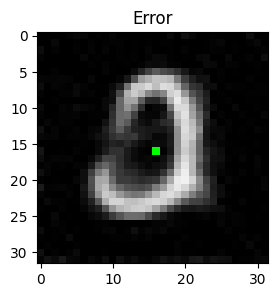

In [36]:
# Choose error: in this ase increase or decrease the value of a pixel
row, col = 16, 16

error = torch.zeros((1,1,32,32), device=device)
error[:,:,row,col] = +1

error_img = (0.5*(x0_pred+1)).clamp(0,1).clone()[0,0,:,:].detach().cpu().tile(3,1,1).numpy().transpose([1,2,0])
error_img[row,col,:] = [0,1,0]

plt.figure(figsize=(3,3))
plt.imshow(error_img)
plt.title("Error")
plt.show()

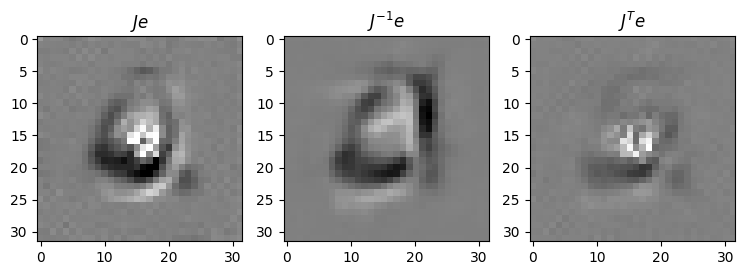

In [37]:
import scipy.linalg

# Compare the different update directions
# Inexact Newton
je = torch.matmul(J.reshape(32*32,32*32), error.reshape(32*32,1))
je = je/je.abs().quantile(0.99)

# Exact Newton
jinve = scipy.linalg.lstsq(J.reshape(32*32,32*32).cpu().numpy(), error.reshape(32*32,1).cpu().numpy(), cond=5e-1)[0]
jinve = torch.from_numpy(jinve).to(device)
jinve = jinve/jinve.abs().max()

# Gradient descent
jte = torch.matmul(J.reshape(32*32,32*32).T, error.reshape(32*32,1))
jte = jte/jte.abs().max()

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(je.reshape(32,32).cpu().numpy(), vmin=-1, vmax=1)
ax[0].set_title("$Je$")
ax[1].imshow(jinve.reshape(32,32).cpu().numpy(), vmin=-1, vmax=1)
ax[1].set_title("$J^{-1}e$")
ax[2].imshow(jte.reshape(32,32).cpu().numpy(), vmin=-1, vmax=1)
ax[2].set_title("$J^{T}e$")
plt.show()

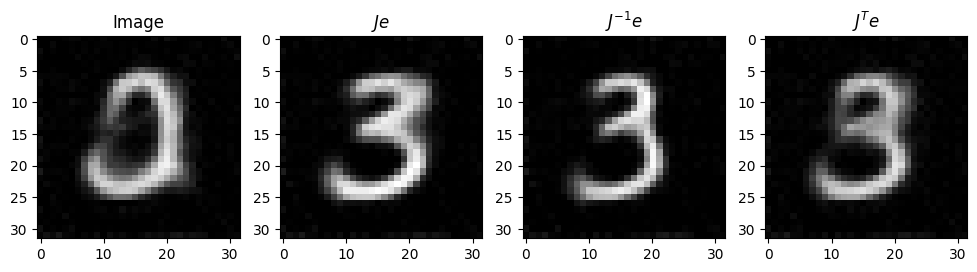

In [38]:
# Perform step with computed updates
l = 1.0

xt_je = xt + l*je.reshape(1,1,32,32)
xt_jinve = xt + l*jinve.reshape(1,1,32,32)
xt_jte = xt + l*jte.reshape(1,1,32,32)

x0_je, _ = model_pred(net, xt_je, t)
x0_jinve, _ = model_pred(net, xt_jinve, t)
x0_jte, _ = model_pred(net, xt_jte, t)

fig, ax = plt.subplots(1, 4, figsize=(12,3))
ax[0].imshow(x0_pred.detach().cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
ax[0].set_title("Image")
ax[1].imshow(x0_je.detach().cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
ax[1].set_title("$Je$")
ax[2].imshow(x0_jinve.detach().cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
ax[2].set_title("$J^{-1}e$")
ax[3].imshow(x0_jte.detach().cpu().numpy()[0,0,:,:], vmin=-1, vmax=1)
ax[3].set_title("$J^{T}e$")
plt.show()